### Ensure that the VPN is working

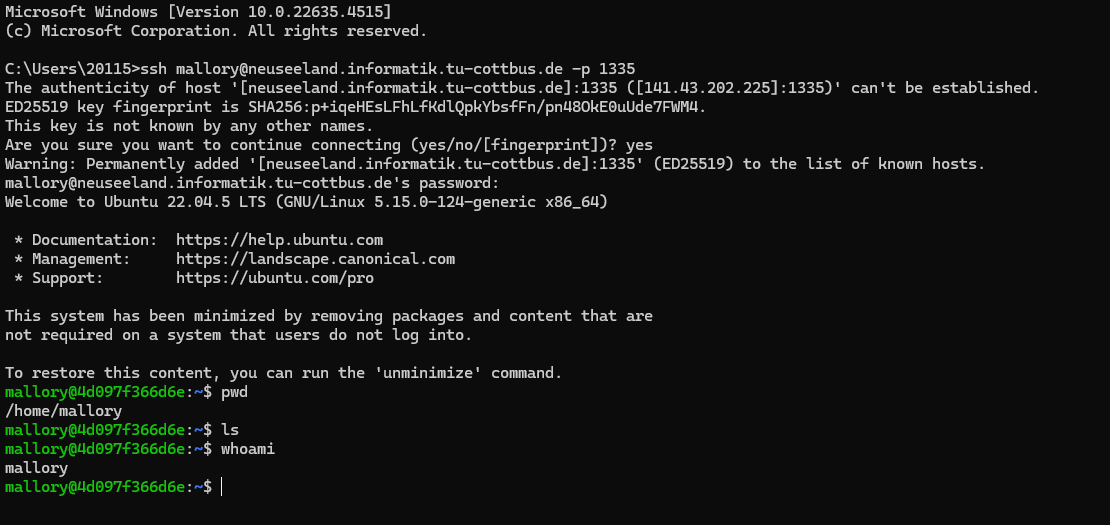

### useful tables
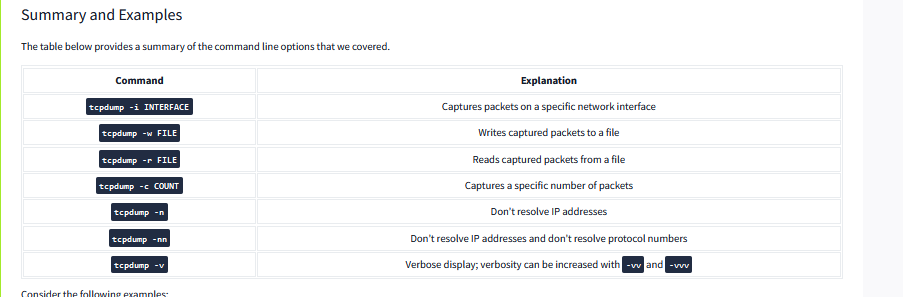
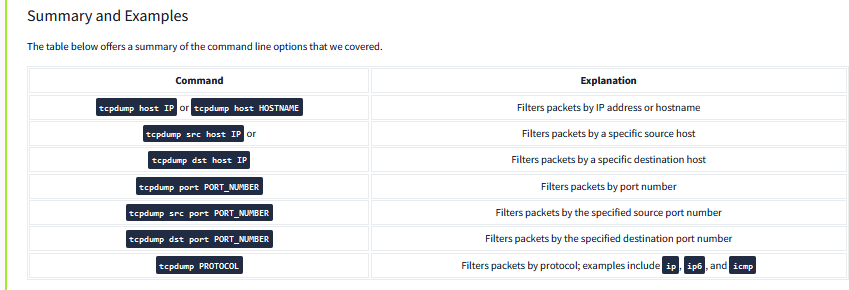
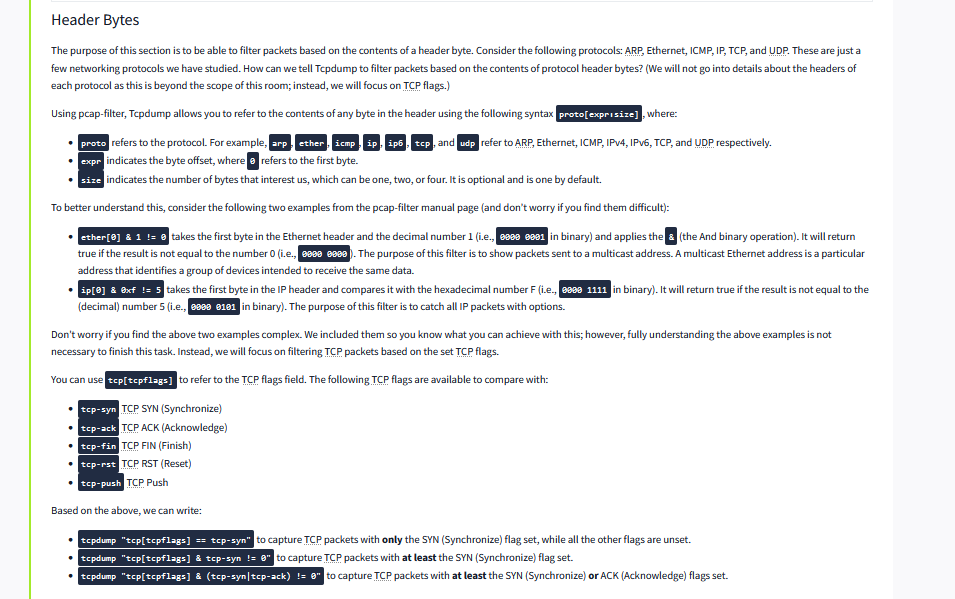
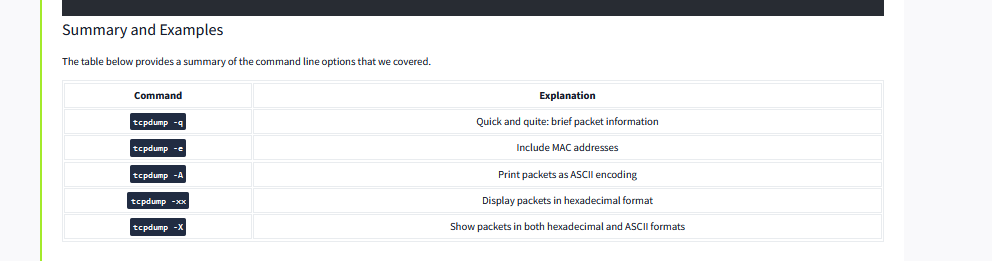

### Resolving IP Addresses
* According to the following screenshot: 
    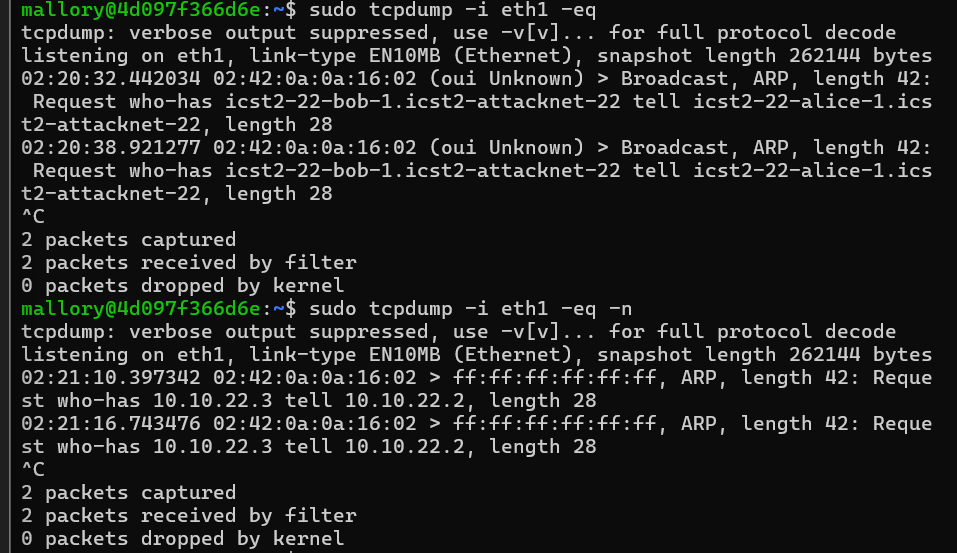
* Bob IP is 10.10.22.3
* Alice IP is 10.10.22.2
* my IP (mallory) 10.10.22.4

### Ensure good connection: 
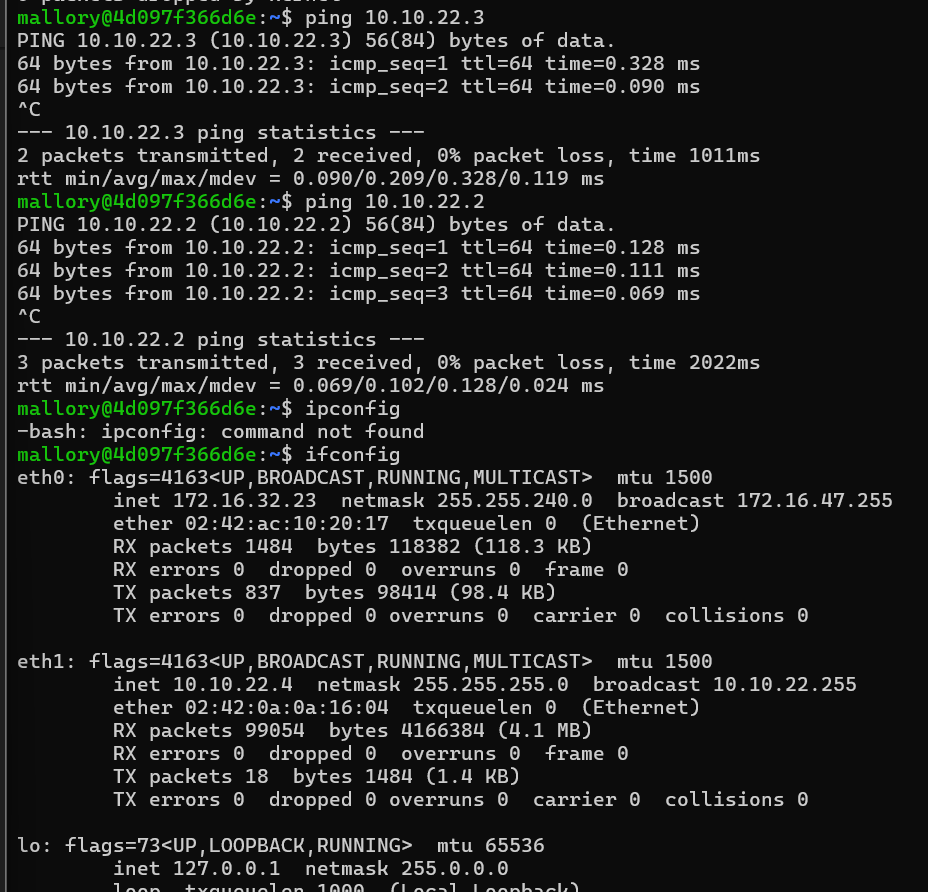

### Code explaination
* Lets examine the given code and understand how it works to be able to successfully use it.
1. The main goal of the file is to send a single Ethernet frame to a specified destination address, containing a given protocol and payload. 
2. it takes 4 arguments:
   1. iface: the interface on which we work, in our case it is eth1
   2. destination: the target MAC address, in our case (Bob's, and Alice's)
   3. payloadProto: in our case it will be ARP
   4. payloadFile: the content of the payload, which in our case should be ARP reply.
3. we are using sockets, and arp libraries. 
4. now lets get deeper in the logic:
   1. we parse all the arguments and validate them:
      1.  so argv[1] is the interface, and we check if its length was > IFNAMSIZ we exit with error, as IFNAMSIZ is a constant defined in the <net/if.h> library specifies the  maximum length of a network interface name 
      2.  after that we copy that name into our predefined structure, with the IFNAMSIZ length. 
      3.  we do the same for the destination MAC address
      4.  then we tokenize the MAC address, using the : as splitor, and take each item before it and store it in our **dst** array
      5.  then we convert the protocol string into integer using strtol, given these parameters
          1.  the protocol name
          2.  NULL means that there is no need for end-pointer, which is used to know where is the address of the first invalid character in the given protocol.
          3.  16 means that the input is in the Hex format
      6.  then we open the payload file and read its content
          1.  get its size
          2.  ensure it is within the allowed size range
          3.  then reading its content into the buffer.
          4.  then close the buffer
      7.  now its time for processing and dealing with the network
          1.  create a layer2 socket, which deals with the MAC addresses withing the same network. 
          2.  it takes the following parameters: 
              1.  PF_Packet -> specifies that this is a socket packet for working in the second layer. 
              2.  SOCK_DGRAM -> specifies that the ethernet header will be generated by OS not manually. 
              3.  htons(ETH_P_ALL) -> indicates that socket should capture all protocol types not a specific one. 
          3.  then we configure the link layer (**ll**) socket address family and protocol, indicating that it works in the layer 2, and the used protocol is ARP. 
          4.  then we try to obtain a network interface index, which is a unique value identifies a specific network interface on the network, so we need to get this of eth1 on our system.
          5.  this is important because when dealing with raw sockets, we need to specify the exact interface over which the packet must be send, which is **eth1** in our case. 
          6.  to do so, we use **ioctl()** which takes the following parameters: 
              1.  **SIOCGIFINDEX**:  ioctl operation that retrieves the interface index of the sepecified network device like **eth1**
              2.  ifreq is interface request previously defined, so we send it by reference to store our result in its **ifr_ifindex** parameter.
          7.  now after retrieving the interface request index, we should store it in our link layer interface index.
          8.  then define the length of the physical address which we know that MAC address length is 6 bytes. 
          9.  then we copy the destination address in this field. 
      8.  now its time for sending the message
          1.  we use sendto method to send the packet over the network, with the following parameters:
              1.  the socket on which we need to send the data.
              2.  pointer to the buffer which contains the payload. 
              3.  the length of the payload in bytes. 
              4.  the flags needed, but in our case we need no flags. 
              5.  the link layer, which indicates:
                  1.  the interface address
                  2.  the destination address
                  3.  the protocol type. 
              6.  the length of this link layer.
      9.  after we finish we just close this socket.

### IP Addresses and MACs:
* Alice: 10.0.3.2 - 52:54:00:12:35:02
* Bobs: 10.0.3.3 - 52:54:00:12:35:03
* me: 10.0.3.4 - 52:54:00:12:35:04


### Very important note:
* even if the poisoning was occured successfully, no packets will be sniffed until we enable sniffing in our machine, and this occurs using this command: 
  > echo 1 | sudo tee /proc/sys/net/ipv4/ip_forward
* and to avoid noticability, we can send our MAC address in a periodic mannar using a loop
  '''
    while true; do
    sudo ./raw_packet eth1 00:11:22:33:44:55 0x0806 payloadAlice.bin
    sudo ./raw_packet eth1 00:11:22:33:44:55 0x0806 payloadBob.bin
    sleep 1
    done
  '''
  

### Interesting Screen
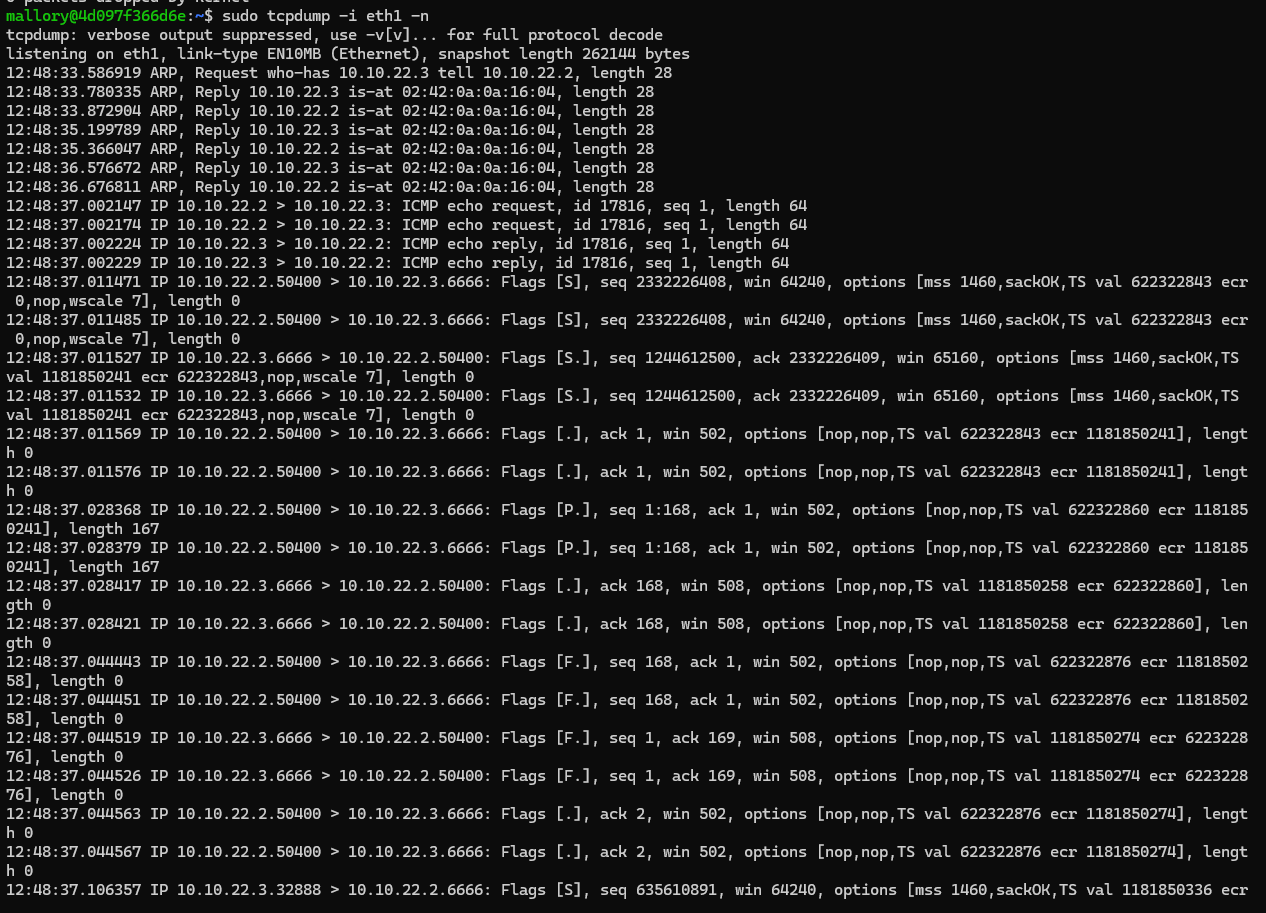
* When we see this screen this indicates that we have successfully poisoned the traffic, and we have the traffic on our device now.
* now its turn for analysis

### First Blick: 
* In the first blick we can notice many things:
  1. there are some dupplicates, and this should be reasonable, because we are applying spoofing, so the same packet is sent twice on the network to two different machines. 
  2. there are some packets with different flags like: 
     * [S] -> this is SYN packet
     * [S.] -> this is SYN-ACK packet
     * [.] -> this is ACK packet
     * [P] -> this is PSH related to the data -> means the data is sent, it is usually used in protocols like HTTP. 
     * [F] -> this is FIN packet to end the communincation.
     * [R] -> this is reset packet to reset the communication

### Now What?
* all what we need to do is to use tcpdump and allow it to show the output in the ASCII format using this flag **-A**
  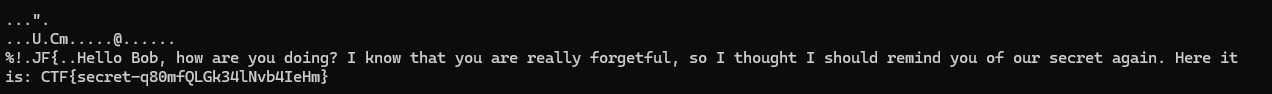

# Summary for all commands: 
1. Create an ARP Reply payload files, one for BOB, and the other for Alice to poison their caches following this structure: 
   * hardware type 2bytes -> 0001 eth1
   * protocol type 2bytes -> 0800 ipv4
   * MAC add length 1 byte -> 0006 mac is 6 bytes
   * Protocol address length -> 0004 ipv4 is 4 bytes
   * operation 2bytes -> ARP Reply
   * sender MAC -> MAC of the Attacker
   * sender IP -> the spoofed IP (like if we want to lie to Alice put Bob's IP)
   * Target MAC -> Alice MAC
   * Target IP -> Alice IP
2. do the exact same file for bob 
3. convert these file to binary using xxd with .bin extensions. 
4. create a file and write inside it the following script to apply stealth script:
   > touch script.sh
   > vim script.sh
   ```bash
    while true; do
    sudo raw_packet eth1 02:42:0a:0a:16:02 0x0806 payLoadAlice.bin
    sudo raw_packet eth1 02:42:0a:0a:16:03 0x0806 payLoadBob.bin
    sleep 1
    done
   ```
   > :wq!
5. make it excutable
   > chmod +x script.sh
6. run it either in background **&** or in another terminal
   > ./script.sh &
7. allow packet forwarding on your machine
  > echo 1 | sudo tee /proc/sys/net/ipv4/ip_forward
8. execute tcpdump on interface eth1 to listen to the sent data and locate the line using grep
   > sudo tcpdump -i eth1 -n -A | grep "CTF"

> Congrats you got it :)

# Bonus Question:
- **Bonus:** Lets assume the same attackers’ goal and tools but this time Alice and Bob run an
 intrusion detection system capable to detect modified ARP replies, i.e., your attack is not
 allowed to use bogus ARP replies. Can you still mount the ARP spoofing and manage to
 establish yourself as the man in the middle, without using replies? Explain why your solution works
 and think about a possible way to mitigate the issue.

### Answer:
Yes, it is still possible to mount an ARP spoofing-based man-in-the-middle (MITM) attack without sending bogus ARP replies, although the approach would require leveraging ARP requests instead. Here’s how this can be achieved and why it works:

---

### **Solution: Exploiting Gratuitous ARP Requests**
- **Gratuitous ARP**: Gratuitous ARP requests are legitimate ARP messages used by devices to announce their presence or update ARP caches in the network. They are sent without any solicitation and do not require a response.
- **Attack Execution**:
  1. The attacker (Mallory) sends a **gratuitous ARP request** claiming ownership of either Bob’s or Alice’s IP address, associating it with the attacker's MAC address.
  2. Since gratuitous ARP is often not scrutinized as closely as ARP replies, this can still poison the ARP caches of the targets (Alice and Bob).
  3. This establishes Mallory as the MITM, allowing interception and forwarding of traffic between Alice and Bob.

**Why It Works:**
- Many intrusion detection systems (IDS) and ARP defenses focus on detecting **ARP replies** that conflict with expected mappings. Gratuitous ARP requests, being legitimate, may bypass such filters unless specifically designed to scrutinize these as well.
- Gratuitous ARP does not require a response, making it harder to trace or detect as malicious.

---

### **Mitigation Strategies**
To counter this type of attack, a network can adopt the following measures:

1. **Static ARP Tables**:
   - Configure static ARP entries on critical devices (e.g., Alice and Bob) so that their IP-to-MAC mappings are fixed and cannot be overridden by any ARP packets.
   - **Downside**: This approach is not scalable for large or dynamic networks.

2. **ARP Validation in Intrusion Detection Systems (IDS)**:
   - Extend the IDS to monitor and validate **gratuitous ARP requests** in addition to replies.
   - Check for inconsistencies between claimed MAC-IP mappings and previously observed mappings.

3. **Dynamic ARP Inspection (DAI)**:
   - Use switches with DAI capabilities to inspect ARP packets dynamically.
   - DAI compares ARP requests and replies against a trusted database of IP-to-MAC mappings (e.g., DHCP snooping binding table).

4. **Encryption-Based Communication**:
   - Use secure protocols such as HTTPS or VPNs to encrypt traffic between Alice and Bob.
   - Even if the MITM attack succeeds, encrypted communication prevents the attacker from reading or tampering with the data.

5. **Segregated VLANs**:
   - Limit the attacker's access by segregating network traffic using VLANs.
   - Ensure that only necessary devices can communicate with each other directly.

---

### **Conclusion**
Yes, it is possible to mount an ARP spoofing MITM attack without using ARP replies by exploiting **gratuitous ARP requests**. However, this attack can be mitigated by implementing robust ARP inspection, using encryption for sensitive communication, or enforcing stricter ARP handling policies in the network infrastructure.